In [1]:
from utils import dataloader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload  

import matplotlib.pyplot as plt

import numpy as np

import torch as th
import torch.nn as nn
import os
from datetime import datetime
import matplotlib as mpl
import torch.optim as optim
import pytorch_ssim

import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.patches as patches

In /Users/diegocalanzone/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/diegocalanzone/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/diegocalanzone/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
dataloader = reload(dataloader)

plotsize = 15
img_size = 256

partitions = dataloader.DataPartitions(
    past_frames=4,
    future_frames=1,
    root="../datasets/arda/mini/"
)

dataset = dataloader.DataGenerator(
    root="../datasets/arda/mini/",
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, img_size, img_size, 4),
    output_dim=(partitions.future_frames, img_size, img_size, 3),
    batch_size=4,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
    dynamicity = 0
)

In [3]:
'''
X, Y, extra_batch = dataset.get_data()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0

fig, axs = plt.subplots(1, 4, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# dep, vvx, vvy, btm

axs[0].matshow(X[0,0,0,:,:,3])
axs[0].set_title("BTM")

axs[1].matshow(X[0,0,0,:,:,0])
axs[1].set_title("DEP")

axs[2].matshow(X[0,0,0,:,:,1])
axs[2].set_title("VVX")

axs[3].matshow(X[0,0,0,:,:,2])
axs[3].set_title("VVY")

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
'''

'\nX, Y, extra_batch = dataset.get_data()\n\nX[X > 10e5] = 0 \nY[Y > 10e5] = 0\n\nfig, axs = plt.subplots(1, 4, figsize=(plotsize,plotsize))\n\nfor ax in axs:\n    ax.set_yticklabels([])\n    ax.set_xticklabels([])\n\n# dep, vvx, vvy, btm\n\naxs[0].matshow(X[0,0,0,:,:,3])\naxs[0].set_title("BTM")\n\naxs[1].matshow(X[0,0,0,:,:,0])\naxs[1].set_title("DEP")\n\naxs[2].matshow(X[0,0,0,:,:,1])\naxs[2].set_title("VVX")\n\naxs[3].matshow(X[0,0,0,:,:,2])\naxs[3].set_title("VVY")\n'

### Model

In [4]:
import torch.nn.functional as F
from functools import partial

In [5]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [6]:
if th.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = th.device(dev)
print(device)

cpu


In [8]:
from models.ae import ConvLSTMCell

from models.ae import seq2seq_ConvLSTM
seq2seq_ConvLSTM = reload(seq2seq_ConvLSTM)

net = seq2seq_ConvLSTM.EncoderDecoderConvLSTM(nf=4, in_chan=4, out_chan=3).to(device) # False: many to one

In [9]:
ssim = pytorch_ssim.SSIM()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [10]:
losses = []
errors = []
test_errors = []

def mass_conservation_loss(output, target):

    # output: b, h, w
    diff = 0
    for i,datapoint in enumerate(output):
        target_sum = th.sum(
                th.abs(target[i])
            )
        pred_sum = th.sum(
                th.abs(output[i])
            )

        diff += th.abs(target_sum - pred_sum)/target_sum

    return diff

(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 256, 4)
torch.Size([1, 4, 4, 256, 256])
(1, 4, 256, 

NameError: name 'x' is not defined

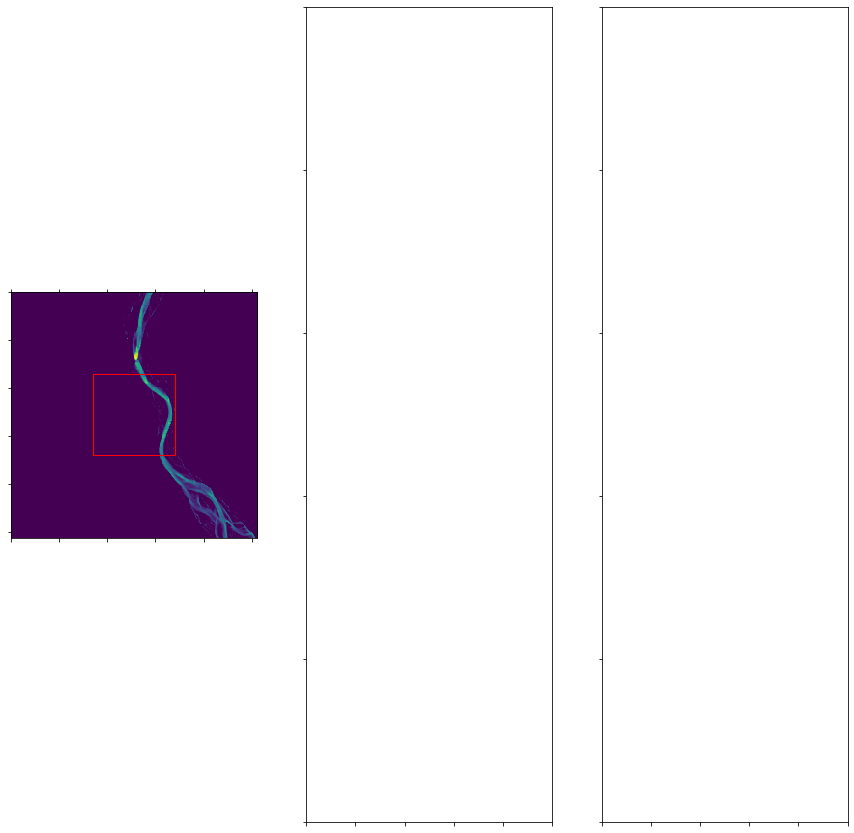

In [17]:
epochs = 200

parts = partitions.get_partitions()

for epoch in range(epochs):  # loop over the dataset multiple times

    for i, area in enumerate(parts):
        
        # If it's valid marked
        if area[2] != None:
            for j, sequence in enumerate(area[1]):

                X, Y = dataset.get_datapoint(i, j)

                # b, s, t, h, w, c -> b, s, t, c, h, w
                X = th.Tensor(X).to(device)
                Y = th.Tensor(Y).to(device)
                X = X.permute(0, 1, 4, 2, 3)
                Y = Y.permute(0, 1, 4, 2, 3)

                optimizer.zero_grad()

                # ---- Predicting

                outputs = net(X, 1) # 0 for layer index, 0 for h index

                # ---- Batch Loss

                xstart=85
                xend=170
                ystart=85
                yend=170
                
                loss = criterion(outputs[:,:,0,ystart:yend,xstart:xend], Y[:,0,:,ystart:yend,xstart:xend])

                loss.backward()
                optimizer.step()

                # print statistics
                losses.append(loss.item())

        print('Finished Training')

In [1]:
th.save(net.state_dict(), "15_8_21.weights")
'''
num_run = len(os.listdir("runs/")) + 1
now = datetime.now()
foldername = "train_{}_{}".format(num_run, now.strftime("%d_%m_%Y_%H_%M_%S"))
os.mkdir("runs/" + foldername)

weights_path = "runs/" + foldername + "/model.weights"
th.save(net.state_dict(), weights_path)
'''

NameError: name 'th' is not defined

In [ ]:
mpl.rcParams['text.color'] = 'k'

plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

In [ ]:
'''
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass
'''

In [ ]:
mpl.rcParams['text.color'] = 'w'
prep = Preprocessing()

In [ ]:
j = np.random.randint(len(y_test))
j = 3
m = 2
k = 4

print("k = {}".format(k))

#k = 5
input = th.unsqueeze(X_test[j, m], 0)
outputs = net(input)

#------------------------------
num_predicted_frames = outputs[0, 0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    frame = frame.cpu().detach().numpy()
    axs[i].matshow(frame)
    axs[i].set_title('t = {}'.format(i))

print("======== Past frames ========")
plt.show()

print("======== True Future vs Predicted frames ========")

#------------------------------
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_test[j,m,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))

plt.show()
#------------------------------
fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(outputs[0,0]):
    attention_mask = outputs[0,1,i].cpu().detach().numpy()
    y_frame = frame.cpu().detach().numpy()
    y_true = y_test[j,m,0,i].cpu().detach().numpy()

    y_frame = np.dot(y_frame, attention_mask)
    y_true = np.dot(y_true, attention_mask)

    print(y_frame[:5,:5])
    print("#-------------")
    print(y_true[:5,:5])
    print("\n\n")

    ssim = prep.pytorch_ssim(y_true, y_frame).item()
    axs[i].matshow(y_frame)
    axs[i].set_title('ssim = {}'.format(ssim))

plt.show()
#------------------------------

In [ ]:
print("k = {}".format(k))
iterations = 4
#k = 5

input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
print("======== Past frames ========")
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i))

plt.show()
#------------------------------
print("======== True vs Autoregressive Pred Frames  ========")
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

true_means = []

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_train[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))
    true_means.append(frame.cpu().detach().numpy().mean())

plt.show()
#------------------------------

#i = np.random.randint(len(X_test))
input = th.unsqueeze(X_train[k][0], 0)

fig, axs = plt.subplots(1, iterations, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

predicted_means = []
for x in range(iterations):
    # first predicted frame only
    output = th.unsqueeze(net(input)[:,:,0,:,:],2)
    # next frame = first predicted from output + btm map
    next_frame = output.detach()
    next_frame = th.cat((next_frame, th.unsqueeze(input[:,2:,0,:,:],2)), axis=1)
    # added on top of (input sequence - first frame)
    input = th.cat((next_frame, input[:,:,1:,:]), axis=2)

    axs[x].matshow(output[0,0,0].cpu().detach().numpy())
    axs[x].set_title('t = {}'.format(x+num_predicted_frames))
    predicted_means.append(output[0,0,0].cpu().detach().numpy().mean())
    #print(np.mean(output[0,0,0].cpu().detach().numpy()))

plt.show()

In [ ]:
mpl.rcParams['text.color'] = 'b'

plt.clf()
plt.plot(range(len(true_means)), true_means,  "-b", label="True frames mean")
plt.plot(range(len(true_means)), true_means,  "*")

plt.plot(range(len(predicted_means)), predicted_means,  "-g", label="Predicted frames mean")
plt.plot(range(len(predicted_means)), predicted_means,  "*")
plt.grid()
plt.legend()
pass

In [ ]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))
'''